In [1]:
import os
os.chdir('../../../')
import numpy as np
import pandas as pd
from neuron import h
from neurostim.cell import Cell
from neurostim.simulation import SimControl
from neurostim.stimulator import Stimulator
from neurostim.utils import convert_polar_to_cartesian_xz
from neurostim.analysis import get_AP_times
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial'],
             'size':10})
# format
# dimensions (A4:  8.27 x 11.69 inches)
text_frac = 0.8
abs_pw = 8.27 # pagewidth
abs_pl = 11.69 # pagelength
pw = text_frac * abs_pw
pl = text_frac * abs_pl
# others
dpi=600

### Model Configuration
* cell type (loaded from ".hoc" file)
    * L5: 'L5.hoc' or L23: 'L23.hoc'
* ChR2 distribution inside cell
    * uniform: 'uniform'
    * soft soma targeting: 'shemesh_supfig9b_exp_yoff'
    * strict soma targeting: 'shemesh_supfig9b_exp_lin_yoff'
* ChR2 expression level (number ChR2 molecules in neuron's membrane)
    * typical number for L5 size (Foutz et al 2012): 10354945, is automatically scaled if 'L23.hoc' is selected
* cell depth in cortex (distance cortical surface - soma), [um]
    * {'L23': 400, 'L5': 1170}
* light model
    * currently only feasible model is for optical fiber [Foutz et al 2012]: 'foutz_et_al2012'
* optical fiber diameter
    * e.g. 25, 50, 100, 200, 400, um
* numerical aperture of fiber (changes beam divergence)
    * e.g. 0.1, 0.22, 0.39, 0.5
* light power [mW]
    * e.g. 1e-5 to 1e-2
* light duration [ms]
    * e.g. 30ms or 200ms
* position of light source on the cortical surface relative to soma of the neuron
    * radial distance: radius [um]
    * angle

## other parameters (meta params for simulation, analysis params etc.)
* total recording time of simulation
* AP threshold: threshold defining an action potential: 0mV
* light delay: 1ms (stim onset after simulation start)
* interpol_dt: 0.1ms (interpolation time for simulation results as simulation has adaptive steps)

In [2]:
# model config 1 ---- *** DO NOT RERUN ***
# NEURON simulator setup is corrupted if reinitialized in a running kernel, rerun complete notebook

# neuron model
hoc_file = 'L5'
# cortical depth of neuron models
cortical_depth = {'L23': 400, 'L5': 1170} #um

# select 4 logarithmically ascending expression levels
expr_levels = np.exp(np.linspace(np.log(5), np.log(100), 4))
print('logarithmically ascending expression levels between relative 5 and 100: ', expr_levels)
expr_levels = [0.05, 0.15, 0.4, 1]
print('roughly logarithmically ascending expression levels between relative 5 and 100 (manually selected): ', expr_levels)
# ChR2 expression distribution and level
chanrhod_distribution = 'uniform' 
chanrhod_soma_density = 13e9*1 # 1/cm2

# NEURON setup
h.load_file("stdrun.hoc")
h.cvode_active(1)
# load cell and create stimulation object
cell = Cell(
    hoc_file="simneurostim/model/hoc/" + str(hoc_file) + ".hoc",
    cortical_depth=cortical_depth,
    ChR_soma_density=float(chanrhod_soma_density),
    ChR_distribution=str(chanrhod_distribution),
    rm_mech_from_secs=None,
)

logarithmically ascending expression levels between relative 5 and 100:  [  5.          13.57208808  36.84031499 100.        ]
roughly logarithmically ascending expression levels between relative 5 and 100 (manually selected):  [0.05, 0.15, 0.4, 1]
	1 
	1 
	1 
	1 


In [3]:
# model config 2 (can be adapted and rerun without restarting notebook kernel)
# init stimulator
stimulator = Stimulator(
    diameter_um=200, 
    NA=0.22
) 
# init simulation
simcontrol = SimControl(
    cell=cell,
    stimulator=stimulator
)

In [4]:
# run simulation
sim_data = simcontrol.run(
    temp_protocol=dict(
        duration_ms=200,
        delay_ms=10,
        total_rec_time_ms=230,
    ),
    stim_location=(0, 0, 0),
    stim_intensity_mWPERmm2=300,
    rec_vars=(
        ['time [ms]', 'V_soma(0.5)'],
        ['h._ref_t', 'h.soma(0.5)._ref_v'],
    ),
    interpol_dt_ms=0.1,
)   
sim_data.to_hdf('paper/NEW_FIGURES/FIG_S4/data_expression'+str(chanrhod_soma_density)+'.hdf', key='first')

In [5]:
# load sim data of the 4 expression levels:
data = []
for expr_lvl in expr_levels:
    df = pd.read_hdf('paper/NEW_FIGURES/FIG_S4/data_expression'+str(expr_lvl*13e9)+'.hdf')
    df['expr_lvl']= expr_lvl
    data.append(df)
data = pd.concat(data).set_index('expr_lvl')

In [6]:
data

,time [ms],V_soma(0.5)
expr_lvl,,
0.05,0.0,-71.044277
0.05,0.1,-71.047733
0.05,0.2,-71.051981
0.05,0.3,-71.056349
0.05,0.4,-71.060784
...,...,...
1.00,229.5,-66.555835
1.00,229.6,-66.600171
1.00,229.7,-66.644508


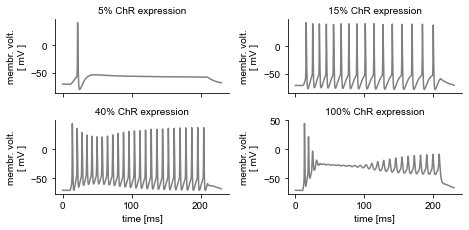

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(pw,0.5*pw))
ax = ax.flatten()
for i, expr_lvl in enumerate(expr_levels):
    data.loc[expr_lvl].plot("time [ms]","V_soma(0.5)", ax=ax[i], legend=False, color='gray')
    ax[i].set_title("{0:.0%}".format(expr_lvl)+' ChR expression', fontsize=10)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_ylabel('membr. volt.\n[ mV ]')
    if i<2:
        ax[i].set_xticklabels([])
        ax[i].set_xlabel('')
    
fig.tight_layout()
fig.savefig('paper/NEW_FIGURES/FIG_S4/figure.png', dpi=dpi, facecolor='white')
plt.show()